# Training and Testing

In [1]:
import numpy as np
import os
import constants as cs
import globali as gg
import settings
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import custom_data_generator as cdg 

### Load configuration data

In [2]:
# Load actions and counters
gg.actions, gg.counters = settings.read_yaml_fields()
label_map = {label:num for num, label in enumerate(gg.actions)}

In [3]:
label_map.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57])

In [4]:
classes = list(label_map.values())
values = list(gg.counters.values())
plt.figure(figsize=(10, 6))
plt.bar(classes, values, color='skyblue')
plt.title('Distribution')
plt.xlabel('Classes')
plt.ylabel('Instances')
plt.savefig("./temp/instogram")
plt.close()

### Read keypoints and split train and test set

In [5]:
sequences, labels = [], []

# get all the keypoints
for action in tqdm(gg.actions, desc="Processing Actions"):
    for sequence in range(gg.counters[action]):
        window = []
        for frame_num in range(cs.NUM_FRAME):
            res = np.load(os.path.join(cs.KEYPOINTS_FOLDER, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

display(np.array(sequences).shape)   
display(np.array(labels).shape)

Processing Actions: 100%|██████████| 58/58 [01:16<00:00,  1.32s/it]


(4921, 30, 1662)

(4921,)

In [6]:
# generate X and y
X = np.array(sequences)
y = to_categorical(labels).astype(int)

display(X.shape)
display(y.shape)

(4921, 30, 1662)

(4921, 58)

In [7]:
# split dataset into train, test and validation set (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

display(X_train.shape)
display(X_test.shape)
display(X_val.shape)
display(y_train.shape)
display(y_test.shape)
display(y_val.shape)

(3936, 30, 1662)

(493, 30, 1662)

(492, 30, 1662)

(3936, 58)

(493, 58)

(492, 58)

In [5]:
# split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y)

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4428, 30, 1662)

(493, 30, 1662)

(4428, 58)

(493, 58)

### Folders

In [8]:
def create_folder_for_training(number):
    # create folders
    log_f = os.path.join(cs.LOGS_FOLDER, 'log_' + str(number), '')
    model_f = os.path.join(cs.MODELS_FOLDER, 'model_' + str(number))
    os.makedirs(log_f, exist_ok=True)
    os.makedirs(model_f, exist_ok=True)
    log_f = "D:\logs"
    return log_f, model_f

In [9]:
log_f, model_f = create_folder_for_training(333333)

### Logs

In [10]:
# log
tensorboard_callback = TensorBoard(log_dir=log_f, histogram_freq=1)
training_log = os.path.join(log_f, 'train_log.csv')
csv_logger = CSVLogger(training_log, append=True)

### Models

In [11]:
# TEST LSTM

np_actions = np.array(list(gg.actions))
print(np_actions.shape[0])
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30, 1662)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(np_actions.shape[0], activation='softmax'))

58


In [12]:
# TEST GRU

np_actions = np.array(list(gg.actions))
print(np_actions.shape[0])
model = Sequential()
model.add(GRU(128, return_sequences=True, activation='tanh', input_shape=(30, 1662)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(GRU(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(GRU(32, return_sequences=False, activation='tanh'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(np_actions.shape[0], activation='softmax'))


58


### Training

In [12]:
# iperparameters
batch_size = 32
train_generator = cdg.CustomDataGenerator(X_train, y_train, batch_size=batch_size, augment_data=True)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=40, restore_best_weights=True)
best_model_path = os.path.join(model_f, 'best_model.h5') 
checkpoint = ModelCheckpoint(best_model_path, monitor='loss', save_best_only=True)
#history = model.fit(train_generator, epochs=2000, validation_data=(X_val, y_val), callbacks=[early_stopping,
                                                                                              #   checkpoint,
                                                                                              #   csv_logger,
                                                                                              #   tensorboard_callback])

history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_val, y_val), callbacks=[early_stopping,
                                                                                              checkpoint,
                                                                                              csv_logger,
                                                                                              tensorboard_callback])

# save best model
final_model_path = os.path.join(model_f, 'final_model.h5')
model.save(final_model_path)


Epoch 1/2000
123/123 [==============================] - ETA: 0s - loss: 4.0151 - categorical_accuracy: 0.0302

C:\Users\Paolo\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


123/123 [==============================] - 27s 151ms/step - loss: 4.0151 - categorical_accuracy: 0.0302 - val_loss: 3.9658 - val_categorical_accuracy: 0.0488
Epoch 2/2000
123/123 [==============================] - 17s 139ms/step - loss: 3.6926 - categorical_accuracy: 0.0495 - val_loss: 3.7681 - val_categorical_accuracy: 0.0305
Epoch 3/2000
123/123 [==============================] - 17s 138ms/step - loss: 3.4483 - categorical_accuracy: 0.0841 - val_loss: 3.5567 - val_categorical_accuracy: 0.0691
Epoch 4/2000
123/123 [==============================] - 17s 136ms/step - loss: 3.2130 - categorical_accuracy: 0.1057 - val_loss: 3.2673 - val_categorical_accuracy: 0.1016
Epoch 5/2000
123/123 [==============================] - 17s 138ms/step - loss: 2.9929 - categorical_accuracy: 0.1504 - val_loss: 2.8799 - val_categorical_accuracy: 0.1484
Epoch 6/2000
123/123 [==============================] - 17s 138ms/step - loss: 2.8031 - categorical_accuracy: 0.1743 - val_loss: 2.7267 - val_categorical_accu

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           916992    
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 dense (Dense)               (None, 30, 64)            8256      
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 dense_1 (Dense)             (None, 30, 64)            4160      
                                                                 
 lstm_2 (LSTM)               (None, 32)                1

In [14]:
# Load the weights pf trained model
model.load_weights('models/model_31/best_model.h5')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'models/model_31/best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Evaluation using Confusion Matrix and Accuracy

In [15]:
y_pred = model.predict(X_test)

16/16 [==============================] - 3s 58ms/step


In [16]:
np_actions[np.argmax(y_pred[10])]

't'

In [17]:
np_actions[np.argmax(y_test[10])]

't'

In [18]:
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(y_pred, axis=1).tolist()

In [19]:
print(y_true)

[1, 27, 50, 52, 21, 1, 22, 23, 52, 22, 5, 27, 49, 12, 49, 4, 43, 41, 47, 32, 41, 52, 3, 4, 48, 14, 19, 34, 33, 28, 23, 8, 13, 11, 29, 45, 16, 4, 53, 57, 55, 16, 2, 1, 16, 17, 32, 47, 44, 9, 29, 1, 23, 21, 46, 31, 47, 8, 53, 31, 50, 56, 1, 52, 29, 0, 25, 49, 14, 28, 4, 47, 16, 45, 0, 20, 46, 23, 17, 29, 2, 15, 36, 38, 21, 41, 41, 20, 9, 31, 37, 22, 49, 15, 28, 52, 52, 37, 7, 8, 19, 49, 21, 21, 4, 27, 55, 24, 17, 37, 7, 57, 46, 33, 20, 3, 22, 8, 33, 47, 14, 48, 36, 39, 31, 42, 48, 37, 53, 33, 39, 46, 29, 23, 11, 32, 46, 43, 23, 38, 19, 12, 9, 21, 29, 35, 47, 32, 0, 11, 17, 10, 12, 26, 12, 24, 5, 4, 4, 42, 35, 15, 11, 25, 7, 30, 30, 57, 50, 46, 27, 26, 12, 32, 3, 56, 27, 55, 13, 49, 16, 36, 31, 36, 19, 26, 57, 2, 7, 21, 57, 32, 10, 46, 3, 55, 11, 34, 41, 7, 17, 55, 30, 23, 47, 14, 41, 53, 43, 48, 37, 30, 43, 3, 23, 5, 15, 31, 3, 26, 35, 55, 14, 50, 32, 34, 11, 48, 43, 40, 53, 39, 15, 22, 28, 41, 34, 13, 36, 32, 15, 35, 26, 1, 52, 4, 16, 0, 55, 9, 43, 39, 15, 37, 24, 25, 33, 30, 28, 33, 19

In [20]:
print(y_pred)

[1, 27, 50, 52, 21, 1, 22, 23, 52, 22, 5, 27, 49, 12, 49, 4, 43, 41, 47, 32, 41, 52, 3, 4, 48, 14, 19, 34, 33, 28, 39, 8, 13, 11, 9, 45, 16, 4, 8, 57, 55, 16, 2, 1, 16, 17, 32, 47, 42, 9, 29, 4, 23, 21, 46, 31, 47, 8, 53, 31, 20, 56, 1, 52, 29, 46, 25, 49, 14, 28, 4, 47, 1, 45, 0, 20, 46, 23, 19, 25, 2, 15, 36, 38, 21, 41, 41, 20, 9, 31, 37, 22, 49, 15, 28, 52, 52, 37, 7, 8, 19, 49, 21, 21, 4, 38, 55, 42, 17, 37, 7, 36, 46, 33, 20, 3, 22, 8, 33, 3, 7, 48, 36, 39, 31, 50, 48, 43, 53, 33, 45, 46, 29, 23, 11, 32, 46, 43, 23, 38, 19, 12, 9, 21, 29, 35, 47, 32, 0, 11, 17, 10, 12, 26, 12, 24, 5, 4, 4, 42, 35, 15, 11, 25, 7, 30, 30, 57, 50, 46, 27, 26, 12, 32, 3, 56, 38, 55, 36, 49, 16, 36, 31, 36, 19, 5, 57, 2, 7, 21, 57, 32, 18, 46, 3, 20, 11, 34, 41, 7, 17, 55, 30, 23, 53, 14, 41, 37, 17, 48, 37, 30, 43, 3, 23, 5, 15, 31, 3, 26, 35, 55, 14, 50, 32, 34, 11, 48, 43, 51, 53, 39, 15, 22, 28, 3, 34, 13, 36, 32, 15, 35, 26, 1, 52, 4, 36, 3, 55, 9, 43, 39, 15, 53, 24, 25, 33, 30, 28, 33, 19, 30, 

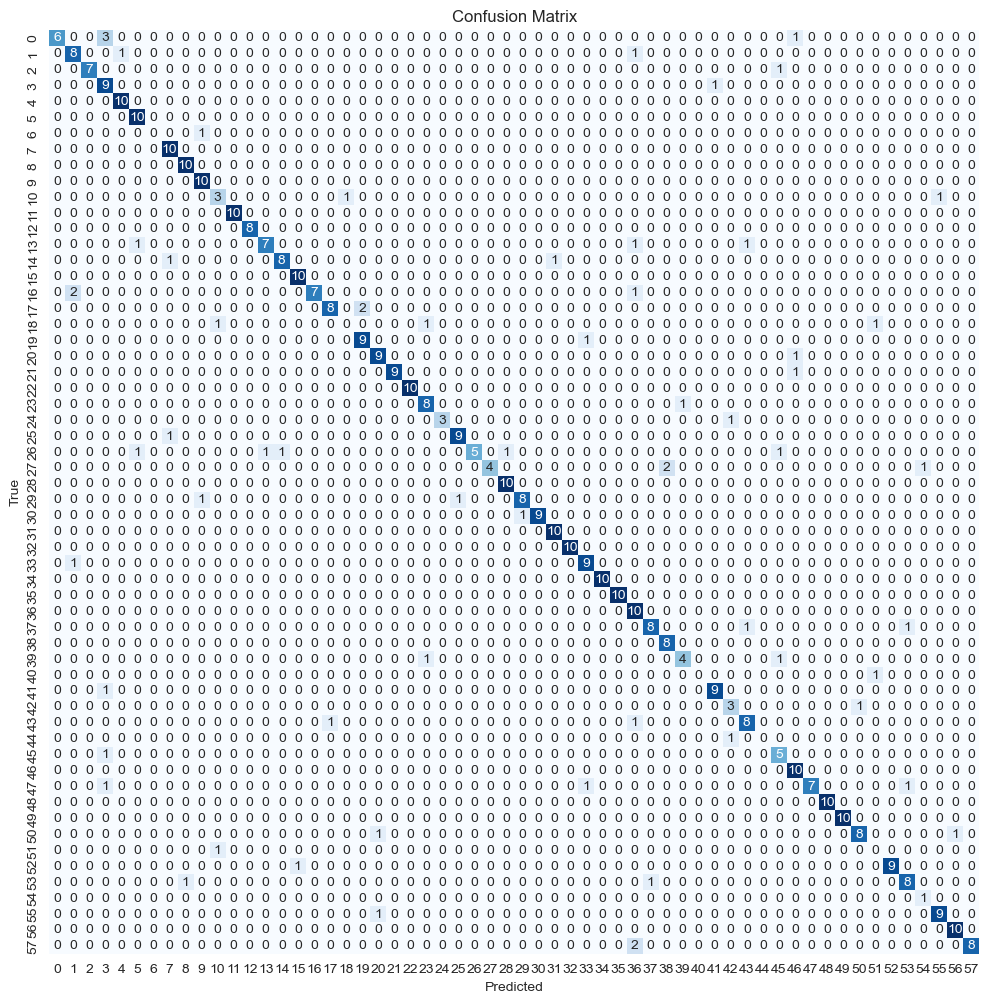

In [21]:
# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# show confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# save confusion matrix into file JPG
plt.savefig(model_f + '/confusion_matrix.jpg', format='jpg')
plt.show()
plt.close()

In [22]:
accuracy_score(y_true, y_pred)

0.8681541582150102

In [23]:
# Evaluate model
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.8695118427276611 / Test accuracy: 0.8681541681289673
